In [2]:
import pandas as pd
import os, sys
import numpy as np

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../..')))

from utils.prediction_utils import *

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb

random_seed = 42

In [3]:
base_dir = "/Users/andrew/Desktop/Harvard/idreos-research/gpu_profiling/experiments/data"
X, y = get_data("sdpa", base_dir, sample_rate=1.0)
X.info()

0it [00:00, ?it/s]

24it [00:33,  1.41s/it]
100%|██████████| 4/4 [00:06<00:00,  1.53s/it]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 464256 entries, 0 to 464255
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   b                  464256 non-null  int64  
 1   h                  464256 non-null  int64  
 2   s_q                464256 non-null  int64  
 3   s_kv               464256 non-null  int64  
 4   d_qk               464256 non-null  int64  
 5   d_v                464256 non-null  int64  
 6   gflops             464256 non-null  float64
 7   dtype_16           464256 non-null  bool   
 8   dtype_32           464256 non-null  bool   
 9   dtype_b16          464256 non-null  bool   
 10  backend_cudnn      464256 non-null  bool   
 11  backend_efficient  464256 non-null  bool   
 12  backend_flash      464256 non-null  bool   
 13  is_causal_0        464256 non-null  bool   
 14  is_causal_1        464256 non-null  bool   
dtypes: bool(8), float64(1), int64(6)
memory usage: 28.3

In [11]:
df = pd.concat([X, y], axis=1)
df = df.dropna()
df = df[df["time"] > 0]

In [12]:
gpu_memory_bandwidth = 3352.32 / 1e3  # GB/ms
_PYTORCH_MIN_ALLOCATE = 2**9

def get_dtype_bytes(row):
    if row['dtype_32']:
        return 4
    elif row['dtype_16']:
        return 2
    elif row['dtype_b16']:
        return 2
    else:
        raise ValueError("Unknown dtype in row.")

def get_num_bytes(num_bytes):
    return ((num_bytes / _PYTORCH_MIN_ALLOCATE) * _PYTORCH_MIN_ALLOCATE).apply(math.ceil)

memory_accesses = (
    get_num_bytes(2 * df["b"] * df["h"] * df["s_q"] * df["d_qk"]) +  # Reading Q
    get_num_bytes(2 * df["b"] * df["h"] * df["s_kv"] * df["d_qk"]) +   # Reading K
    get_num_bytes(2 * df["b"] * df["h"] * df["s_kv"] * df["d_v"]) +   # Reading V
    get_num_bytes(df["b"] * df["h"] * df["s_q"] * df["d_v"])      # Writing Output
) * df.apply(get_dtype_bytes, axis=1) / 1e9  # in GB

df["transfer_time"] = memory_accesses / gpu_memory_bandwidth

Train--------
Mean Squared Error: 4.533976109384261
MAPE: 0.012552058004200688
R-squared: 0.9958065968956938


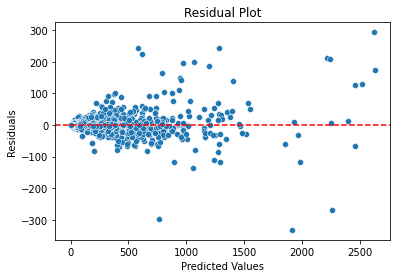

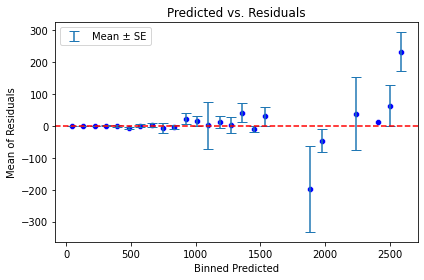

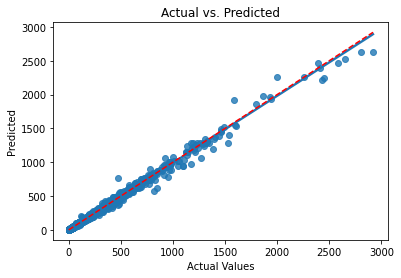

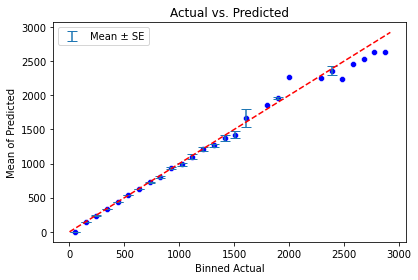

Val--------
Mean Squared Error: 13.824241783788615
MAPE: 0.02365817255003238
R-squared: 0.9887806306529225


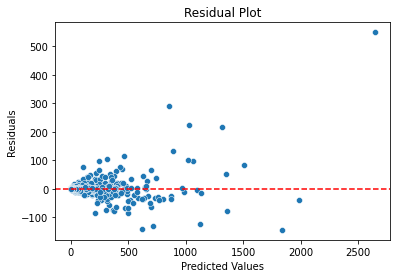

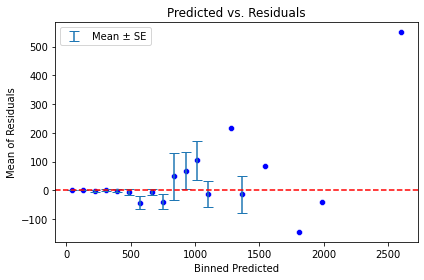

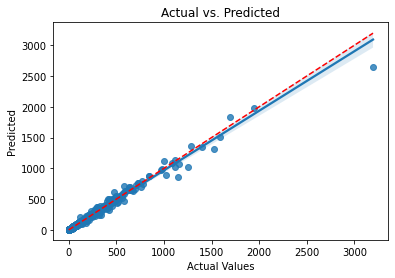

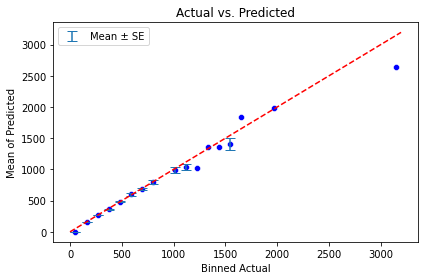

In [14]:
X, y = df.drop(columns=["time"]), df["time"]
X_train, X_val, X_test, y_train, y_val, y_test = get_train_test_split(X, y, return_concat=False)
X_cv = pd.concat([X_train, X_val])
y_cv = pd.concat([y_train, y_val])

tree_model = RandomForestRegressor(max_depth=150, min_samples_split=2, min_samples_leaf=2, max_features=100, random_state=random_seed)
tree_model.fit(X_cv, y_cv)

run_val_pipeline(tree_model, X_cv, X_test, y_cv, y_test, bins=30)

In [15]:
get_feature_importance(X.columns, tree_model)

,Feature,Importance
6,gflops,0.571051
8,dtype_32,0.283707
13,is_causal_0,0.042920
14,is_causal_1,0.042740
2,s_q,0.019594
15,transfer_time,0.014724
11,backend_efficient,0.009884
5,d_v,0.006589
3,s_kv,0.003882
4,d_qk,0.003534
